In [2]:
from ase import Atoms, Atom
from ase.visualize import view
from ase.io import read, write
from ase.build import mx2, add_adsorbate
from ase.constraints import FixAtoms
from ase.build import surface
from ase.data.colors import jmol_colors
from IPython import display
import numpy as np
import os
from ase.collections import g2
from ase.build import molecule

##plot
import pandas as pd
import matplotlib.pyplot as plt 


RISSA software generate a file .rissa with all the configurations, but this file needs a treatment od fata to manipulate. In next code lines you process the file to read and match the configuration of molecule with the MOF structure.  

In [2]:
### Change the number of atoms given in the .rissa file for the number of atoms in the molecule guest ###

f = open('MOPAC_CELL_DATA.rissa','r')
filedata = f.readlines()
f.close()
#print(filedata)

new_lines = []
for line in filedata:
    if line[:2] == '88':
        line=line.replace("88","16") ### especificar !!!number to change 
    else:
        line=line
    new_lines.append(line)
#print(new_lines)

with open('MOPAC_CELL_DATA.rissa','w') as file:
    for line in new_lines:
        file.writelines(line)


## Create an .xyz file for every structure

In [3]:
### create xyz file for every structure
###it is necessary creating a directory called dividingfile 

lines_per_file = 18
smallfile = None
a = []

with open('MOPAC_CELL_DATA.rissa') as bigfile:
    for lineno, line in enumerate(bigfile):
        a.append(lineno % lines_per_file == 0)
        if lineno % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = '/home/joana/postdoc/rissa/benzyl_In/dividingfile/small_file_{}.xyz'.format(lineno/lines_per_file)
            smallfile = open(small_filename, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()
number_structs = a.count(True)        
print('Number of structures xyz: ', number_structs)        

Number of structures xyz:  2183


## Joining  xyz coordinates from mof and xyz molecule

In [4]:
##Reading xyz files
mof_sc = pd.read_table('/home/joana/postdoc/rissa/benzyl_In/mofIn.xyz', #cambiar este path y archivo por el del mof de interes
                       skiprows=2, delim_whitespace=True, header=None)
for i in range(number_structs):
    molecule = pd.read_table('/home/joana/postdoc/rissa/benzyl_In/dividingfile/small_file_{}.0.xyz'.format(i), 
                         skiprows=2, delim_whitespace=True, header=None)

##joinning mof and molecule coordinates
    mof_mol = pd.concat([mof_sc, molecule])


##editar de acuerdo al tipo de atomos que se tienen

    Sc = mof_mol.loc[mof_mol.iloc[:,0]== 'In', :]
    O = mof_mol.loc[mof_mol.iloc[:,0]== 'O', :]
    H = mof_mol.loc[mof_mol.iloc[:,0]== 'H', :]
    C = mof_mol.loc[mof_mol.iloc[:,0]== 'C', :]

    dffinal = pd.concat([Sc, O, H, C], ignore_index=True, names=None )
    dfcoord = dffinal.loc[:, [1,2,3]]

    ###Guardar lines en archivo xyz ### 
    dfcoord.to_csv('mofmol_{}.xyz'.format(i), 
                   columns=None, header=False, index=False, sep=' ')


In [5]:
#check the number of atoms in the system
print(Sc.shape[0], O.shape[0], H.shape[0], C.shape[0])

4 21 24 39


## Writing POSCARS ###

In [6]:
## To use this code, you should cretar previously the POSCAR file with the fistt lines different to xyz
#####coordinates with the data from the optimized CONTCAR ###########
f = open('POSCAR','r') 
filedata = f.readlines()
f.close()
#print(filedata)

for struct in range(number_structs):
    g = open('mofmol_{}.xyz'.format(struct),'r')
    coordinates = g.readlines()
    g.close()
    #print(coordinates)

    new_lines = filedata[:8]

    for line in coordinates:
        line=line
        new_lines.append(line)
    #print(new_lines)

     ##create the directory named POSCARS
    with open('POSCAR_{}'.format(struct),'w') as file:
        for line in new_lines:
            file.writelines(line)

### Obtaining energy from every configuration tested  ##

In [3]:
directory = 'output'
os.chdir(directory)
main = os.getcwd()
#print('this is main directory: ', main)


energies = []
ns = []
for n in range(2183):
    #print(n)
    dir = main + '/' + 'conf_{}'.format(n) 
    os.chdir(dir)
    #print(os.getcwd())
    atoms = read('OUTCAR', format='vasp-out', index=-1)
    energy = atoms.get_potential_energy()
    ns.append(n)
    energies.append(energy)
    #print(n, energy)


    
    
    
    

## Plotting data

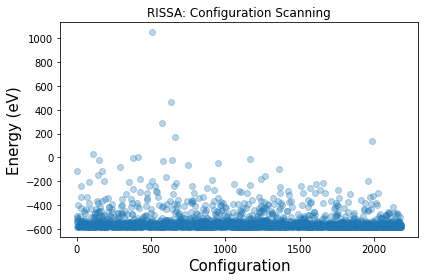

In [9]:

fig, ax = plt.subplots()
ax.scatter(ns, energies,  alpha=0.3)

ax.set_xlabel('Configuration', fontsize=15)
ax.set_ylabel('Energy (eV)', fontsize=15)
ax.set_title('RISSA: Configuration Scanning')


fig.tight_layout()

plt.show()
